# Error Analysis of Decision Tree

In [25]:
# Import needed libraries and packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from matplotlib.patches import Rectangle

import random

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

RSEED=42


In [26]:
# Define the directory containing the files
data_directory = 'data/file_per_night_08_12'

### Load the Data

The data was generated in notebook Decision_Tree1_allData.ipynb.

In [27]:
X_train = pd.read_parquet(os.path.join(data_directory, "train_data_smote.parquet"))
y_train = pd.read_csv(os.path.join(data_directory, "y_train_smote.parquet"))

In [28]:
y_train = y_train['event'].reset_index(drop=True)

In [29]:
test_data = pd.read_parquet(os.path.join(data_directory, "test_data.parquet"))
X_test = test_data.drop(['event', "series_id", "step"], axis=1).reset_index(drop=True)
y_test = test_data['event'].reset_index(drop=True)

### Preproccessing

In [30]:
# Preprossessing of features
scaler = MinMaxScaler()

# Scaling of features
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[5.01291104e-01, 3.10054302e-02, 1.17703925e-01, ...,
        5.00000000e-01, 3.91304348e-01, 2.20338983e-01],
       [3.09890226e-01, 7.49325600e-04, 4.59269376e-02, ...,
        9.66666667e-01, 2.17391304e-01, 7.79661017e-01],
       [3.82330718e-01, 9.59850402e-03, 4.65260328e-01, ...,
        4.66666667e-01, 9.13043478e-01, 6.94915254e-01],
       ...,
       [6.98523919e-01, 0.00000000e+00, 0.00000000e+00, ...,
        7.00000000e-01, 2.17391304e-01, 9.66101695e-01],
       [6.28358761e-02, 7.85007778e-04, 1.14381941e-01, ...,
        5.66666667e-01, 4.34782609e-02, 3.22033898e-01],
       [4.20580900e-01, 1.10269806e-02, 1.53085439e-01, ...,
        7.33333333e-01, 3.47826087e-01, 5.59322034e-01]])

### Training of the model

In [31]:
# Initialize the Classifier
model = DecisionTreeClassifier(random_state=RSEED, max_depth=10)

In [32]:
y_train

0          awake
1          sleep
2          awake
3          awake
4          awake
           ...  
3729771    awake
3729772    awake
3729773    awake
3729774    awake
3729775    awake
Name: event, Length: 3729776, dtype: object

In [33]:
# Train the model on the training data
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [34]:
# Make predictions on the test data
y_pred = model.predict(X_test)

Evaluation of the model performance:

In [35]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 97.46%
Precision on test data: 97.45%
Recall on test data: 97.46%
F1 Score on test data: 97.45%


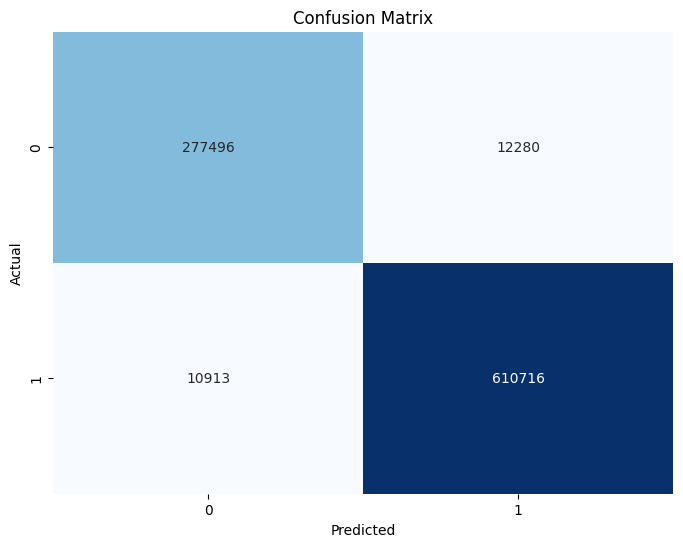

In [36]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Feature importance

Let us have a look at the importance of the different features for the prediciton:

In [37]:
df_imp = pd.DataFrame({'feature': X_test.columns, 'importance': model.feature_importances_})
# sort by importance
df_imp = df_imp.sort_values(by= 'importance', ascending = False)
df_imp

,feature,importance
2,anglez_std,0.619771
25,minutes_since_onset,0.177803
21,enmo_10min_mean,0.117565
29,hour,0.033229
16,enmo_5min_std_shifted,0.027037
24,enmo_10min_std_shifted,0.011411
22,enmo_10min_std,0.003732
23,enmo_10min_mean_shifted,0.002548
14,enmo_5min_std,0.002134
0,anglez,0.000833


The by far most important feature is standard deviation of the z-angle per minute bin, which accounts for over 61% of the prediciton. Other, less important, features are minutes since onset (19%) and the mean of ENMO over 10 minutes (15%).  

# Error Analysis

### Getting the misclassified data into the dataframe df_imp

In [38]:
pred_errors = X_test[y_pred != y_test]
pred_errors = pd.concat([pred_errors, y_test.iloc[pred_errors.index]], axis =1)
pred_errors

,anglez,enmo,anglez_std,enmo_std,slope_enmo,slope_anglez,anglez_outside_45_counter,enmo_over_008_counter,anglez_difference_5_per_min,anglez_5min_mean,...,enmo_10min_std,enmo_10min_mean_shifted,enmo_10min_std_shifted,minutes_since_onset,year,month,day,hour,minute,event
1,-34.250549,0.005250,4.195207,0.018187,-0.002423,0.675508,1,1,2,-59.009266,...,0.030176,0.000033,0.000103,538.0,2017.0,10.0,30.0,5.0,46.0,sleep
27,22.999258,0.008908,17.517556,0.026445,-0.003548,3.474203,0,1,7,-13.604774,...,0.019527,0.002425,0.005012,474.0,2019.0,6.0,7.0,4.0,56.0,awake
78,17.499266,0.043908,11.321201,0.040670,-0.007844,-1.018150,0,11,6,16.048955,...,0.024330,0.019832,0.020959,508.0,2019.0,1.0,18.0,8.0,28.0,sleep
227,81.026909,0.000508,0.283342,0.000271,-0.000013,-0.036163,12,0,0,-6.470856,...,0.002666,0.002898,0.003598,462.0,2018.0,3.0,5.0,7.0,27.0,awake
238,-17.796875,0.114233,21.295410,0.150528,0.036492,-5.322198,0,5,3,-3.347863,...,0.074863,0.255610,0.003981,309.0,2019.0,2.0,23.0,6.0,42.0,sleep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911253,46.094433,0.021842,20.233229,0.007577,-0.000536,5.027605,8,12,2,42.148476,...,0.012442,0.005000,0.000000,564.0,2018.0,8.0,16.0,6.0,40.0,awake
911319,-35.170475,0.019392,4.496460,0.003376,0.000486,-0.980579,0,12,1,-20.432949,...,0.013055,0.020093,0.000086,522.0,2019.0,2.0,27.0,11.0,58.0,sleep
911354,59.925808,0.001758,9.639336,0.002596,-0.000590,2.066749,9,0,1,-1.055152,...,0.012515,0.034197,0.000115,365.0,2018.0,3.0,3.0,12.0,8.0,sleep
911355,-39.402000,0.010542,17.669576,0.015049,0.002863,-0.675385,3,5,4,-15.055335,...,0.008758,0.002307,0.001944,660.0,2017.0,9.0,16.0,11.0,10.0,awake


In [39]:
# load the original test set into a dataframe including event labels
test_set = pd.concat([X_test, y_test], axis =1)

Is there an imbalance in the prediciton with respect to the event class?

In [57]:
per_pal = ['#5BCFC5', '#9E61CD']

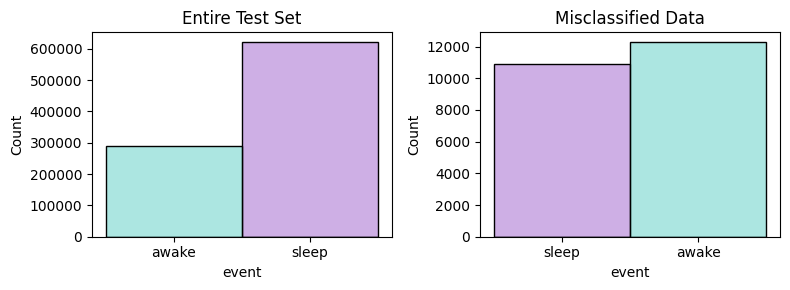

In [65]:
plt.figure(figsize=(8, 3))
# Subplot for orignial test set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 2
sns.histplot(test_set, x='event', hue= 'event', palette = per_pal, legend=False, hue_order=['awake', 'sleep'])
plt.title('Entire Test Set')
# Subplot for missclassified data
plt.subplot(1, 2, 2)
sns.histplot(pred_errors, x='event', hue= 'event',palette = per_pal, legend=False, hue_order=['awake', 'sleep'])
plt.title('Misclassified Data')

plt.tight_layout()

plt.show()

In the original test data set, 'sleep' is the dominating class. Interestingly, in the missclassified data the amount of 'sleep' is even slightly lower than the number of 'awake'. This indicates that our model is better in prediciton 'sleep' than 'awake'.

Let us have a look on the distribution of z-angle values in the misclassified data:

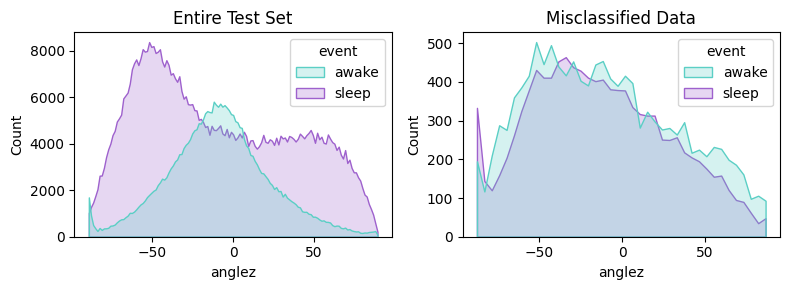

In [64]:
plt.figure(figsize=(8, 3))
# Subplot for orignial test set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 2
sns.histplot(test_set, x = 'anglez', hue='event', palette = per_pal, element='poly', hue_order=['awake', 'sleep'])
plt.title('Entire Test Set')
# Subplot for missclassified data
plt.subplot(1, 2, 2)
sns.histplot(pred_errors, x = 'anglez', hue='event',palette = per_pal, element='poly', hue_order=['awake', 'sleep'])
plt.title('Misclassified Data')

plt.tight_layout()

plt.show()

 In the original data set the distribution of angles were shaped differently for the to classes. During sleep the angles tend to be larger with a higher number at negative values, whereas during wake phases the angle is almost normally distributed around a small negative value. In contrast, in the missclassified data the distributions of z-angle values is very similar between oth classes. This indicates that there is no further information by our model during analysis:

What about the ENMO?

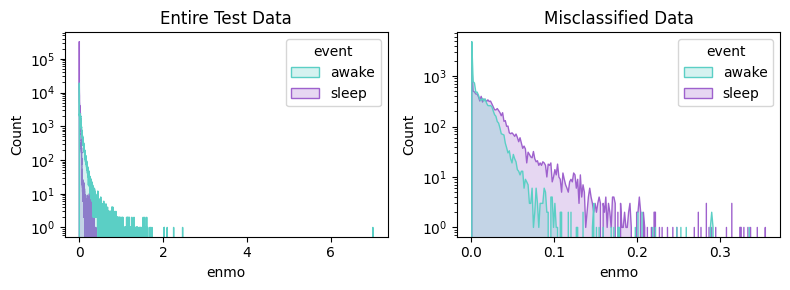

In [66]:
plt.figure(figsize=(8, 3))
# Subplot for orignial test set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 2
sns.histplot(test_set, x='enmo', hue='event', palette = per_pal, element='poly', hue_order=['awake', 'sleep'])
plt.title('Entire Test Data')
plt.yscale('log')
# Subplot for missclassified data
plt.subplot(1, 2, 2)
sns.histplot(pred_errors, x = 'enmo', hue='event', palette = per_pal, element='poly', hue_order=['awake', 'sleep'])
plt.title('Misclassified Data')
plt.yscale('log')

plt.tight_layout()

plt.show()

Interestingly, the maximum ENMO is much less in the misclassified data indicating that our model is able to predict correctly for high ENMO values. Further, the distribution of 'sleep' and 'awake' seems similar between the entire test set and the misclassified data. This indicates that there are no patterns or irregularities overseen by our model.

Because the standard deviation of the z-angle is the most important feature, we want to analyse the distibution of missclassiefied data with respect to this feature:

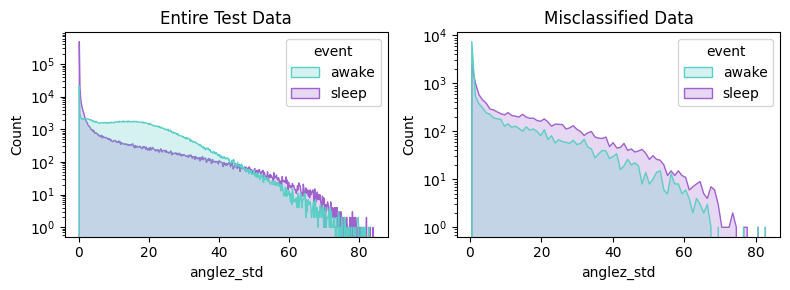

In [67]:
plt.figure(figsize=(8, 3))
# Subplot for orignial test set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 2
sns.histplot(test_set, x = 'anglez_std', hue='event', palette = per_pal, element='poly', hue_order=['awake', 'sleep'])
plt.title('Entire Test Data')
plt.yscale('log')
# Subplot for missclassified data
plt.subplot(1, 2, 2)
sns.histplot(pred_errors, x = 'anglez_std', hue='event', palette = per_pal, element='poly', hue_order=['awake', 'sleep'])
plt.title('Misclassified Data')
plt.yscale('log')

plt.tight_layout()

plt.show()

In addition, the feature 'hour' is also important. How does the distribtion of this feature look like in the different data sets?

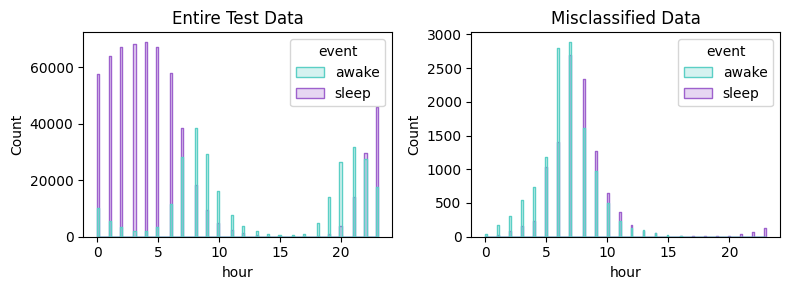

In [68]:
plt.figure(figsize=(8, 3))
# Subplot for orignial test set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 2
sns.histplot(test_set, x = 'hour', hue='event', palette = per_pal, element='step', hue_order=['awake', 'sleep'])
plt.title('Entire Test Data')
# Subplot for missclassified data
plt.subplot(1, 2, 2)
sns.histplot(pred_errors, x = 'hour', hue='event', palette = per_pal, element='step', hue_order=['awake', 'sleep'])
plt.title('Misclassified Data')

plt.tight_layout()

plt.show()

In the entire test data set, we have a lack of data during daytime. This is due to the experimental setup, because the accelerometers were not worn during the day. Interestingly, in the misclassified data, we hae a peak of missclassification in the morning ours. There is almost no misclassification of 'sleep' during night. This indicates that our model was trained to predict, that during night the person is sleeping. Probably, because of personal preferences and habits the model is less acurate on predicting 'sleep' or 'awake' during morning hours, because there is much more variance in the data.

In [45]:
misclassified = []
for i in X_test.index:
    if X_test.index[i] in pred_errors.index:
        misclassified.append(1)
    else:
        misclassified.append(0)
test_evaluation = X_test
test_evaluation['misclassified'] = misclassified

### Analysis of Errors in a randomly selected night

In [46]:
def get_rand_pat(file):
    rand_pat = pd.read_parquet(os.path.join(data_directory,file))
    rand_pat['timestamp'] = pd.to_datetime(rand_pat[['year', 'month', 'day', 'hour', 'minute']])
    return rand_pat

In [47]:
def predicted_y_pat(X_pat,model = model):
    y_pat_pred = model.predict(X_pat)
    return y_pat_pred

In [48]:
def modify_X_pat(X_pat, rand_pat, y_pat_pred):
    X_pat['timestamp'] = pd.to_datetime(X_pat[['year', 'month', 'day', 'hour', 'minute']])
    misclassified = []
    for i in range(len(y_pat_pred)):
        if rand_pat['event'][i] == y_pat_pred[i]:
            misclassified.append(0)
        else:
            misclassified.append(1)
    X_pat['misclassified'] = misclassified
    return X_pat

In [49]:
def make_X_y_pat(rand_pat):
    X_pat = rand_pat.drop(['event', "series_id", "step", "anglez_enmo_ratio", "night", "timestamp"], axis=1).reset_index(drop=True)
    y_pat = rand_pat['event'].reset_index(drop=True)

    # Scaling of features
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scaler.transform(X_pat)
    return X_pat, y_pat

In [50]:
file ='patient_12d01911d509_10.0_random_60_180_minutes.parquet'
rand_pat = get_rand_pat(file)
X_pat, y_pat = make_X_y_pat(rand_pat)
y_pat_pred = predicted_y_pat(X_pat, model)
X_pat = modify_X_pat(X_pat, rand_pat, y_pat_pred)

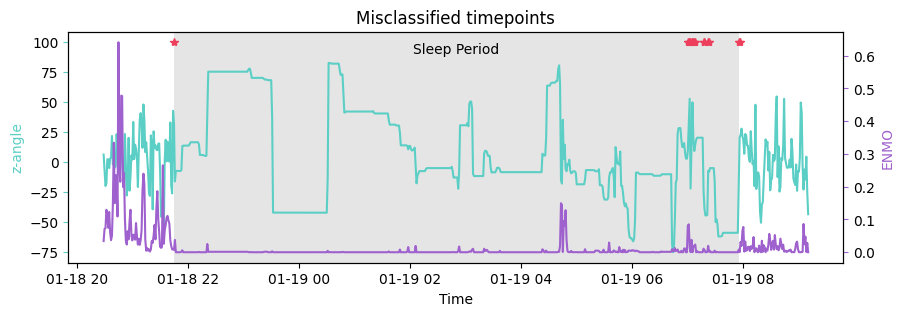

In [69]:
fig, ax1 = plt.subplots(figsize=(10, 3))


# Plot the 'z_angle' values on y-axis
ax1.plot(X_pat['timestamp'], X_pat['anglez'], label='z-angle', color = '#5BCFC5')
# label the timepoints of misclassification
ax1.plot(X_pat.query('misclassified == 1')['timestamp'], [100]*sum(X_pat['misclassified']), marker='*', linestyle='', color = '#ED3F5C')
ax1.set_xlabel('Time')
ax1.set_ylabel('z-angle', color = '#5BCFC5')
ax1.tick_params('y', color = '#5BCFC5')
#ax1.legend(loc='upper left')

# Create a secondary y-axis for 'enmo'
ax2 = ax1.twinx()
ax2.plot(X_pat['timestamp'], X_pat['enmo'], label='ENMO', color='#9E61CD')
ax2.set_ylabel('ENMO', color='#9E61CD')
ax2.tick_params('y', color='#9E61CD')
start_time = rand_pat[rand_pat['event'] == 'onset']['timestamp'][0]
end_time = rand_pat[rand_pat['event'] == 'wakeup']['timestamp'][0]

# mark sleep period
rect = Rectangle((start_time, ax1.get_ylim()[0]), end_time - start_time, ax1.get_ylim()[1] - ax1.get_ylim()[0],
                 linewidth=0, edgecolor='none', facecolor='#CCCCCC', alpha=0.5)
ax1.add_patch(rect)
label_text = 'Sleep Period'
ax1.text(start_time + (end_time - start_time) / 2, ax1.get_ylim()[1] -15, label_text,
         ha='center', va='center', color='black', fontsize=10)

plt.title('Misclassified timepoints')
plt.show()

In [71]:
file ='patient_f6d2cc003183_7.0_random_60_180_minutes.parquet'
rand_pat = get_rand_pat(file)
X_pat, y_pat = make_X_y_pat(rand_pat)
y_pat_pred = predicted_y_pat(X_pat, model)
X_pat = modify_X_pat(X_pat, rand_pat, y_pat_pred)

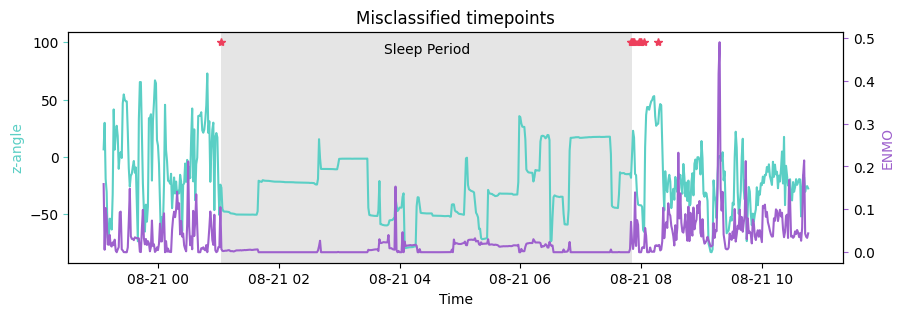

In [73]:
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plot the 'z_angle' values on y-axis
ax1.plot(X_pat['timestamp'], X_pat['anglez'], label='z-angle', color = '#5BCFC5')
# label the timepoints of misclassification
ax1.plot(X_pat.query('misclassified == 1')['timestamp'], [100]*sum(X_pat['misclassified']), marker='*', linestyle='', color = '#ED3F5C')
ax1.set_xlabel('Time')
ax1.set_ylabel('z-angle', color = '#5BCFC5')
ax1.tick_params('y', color = '#5BCFC5')
#ax1.legend(loc='upper left')

# Create a secondary y-axis for 'enmo'
ax2 = ax1.twinx()
ax2.plot(X_pat['timestamp'], X_pat['enmo'], label='ENMO', color='#9E61CD')
ax2.set_ylabel('ENMO', color='#9E61CD')
ax2.tick_params('y', color='#9E61CD')
start_time = rand_pat[rand_pat['event'] == 'onset']['timestamp'][0]
end_time = rand_pat[rand_pat['event'] == 'wakeup']['timestamp'][0]

# mark sleep period
rect = Rectangle((start_time, ax1.get_ylim()[0]), end_time - start_time, ax1.get_ylim()[1] - ax1.get_ylim()[0],
                 linewidth=0, edgecolor='none', facecolor='#CCCCCC', alpha=0.5)
ax1.add_patch(rect)
label_text = 'Sleep Period'
ax1.text(start_time + (end_time - start_time) / 2, ax1.get_ylim()[1] -15, label_text,
         ha='center', va='center', color='black', fontsize=10)

plt.title('Misclassified timepoints')
plt.show()

In [74]:
X_pat.query('misclassified == 1')

,anglez,enmo,anglez_std,enmo_std,slope_enmo,slope_anglez,anglez_outside_45_counter,enmo_over_008_counter,anglez_difference_5_per_min,anglez_5min_mean,...,enmo_10min_mean_shifted,enmo_10min_std_shifted,minutes_since_onset,year,month,day,hour,minute,timestamp,misclassified
117,-26.845774,0.007183,21.756816,0.016275,0.000114,-5.161423,2,2,3,-21.624058,...,0.028904,0.032500,0.0,2017.0,8.0,21.0,1.0,3.0,2017-08-21 01:03:00,1
524,-18.230900,0.070783,47.372205,0.089354,0.011688,-4.574664,8,11,6,-15.614868,...,0.000057,0.000176,407.0,2017.0,8.0,21.0,7.0,50.0,2017-08-21 07:50:00,1
525,1.923225,0.024925,2.985687,0.002139,0.000516,-0.718391,0,12,0,-12.200643,...,0.000058,0.000176,407.0,2017.0,8.0,21.0,7.0,51.0,2017-08-21 07:51:00,1
526,22.722525,0.007542,0.607591,0.001315,0.000309,-0.148200,0,6,1,-4.669792,...,0.000058,0.000176,408.0,2017.0,8.0,21.0,7.0,52.0,2017-08-21 07:52:00,1
527,16.753309,0.026383,15.930265,0.057197,0.007723,-2.208426,0,12,1,1.710687,...,0.000058,0.000176,409.0,2017.0,8.0,21.0,7.0,53.0,2017-08-21 07:53:00,1
532,-42.097332,0.000000,0.256298,0.000000,0.000000,0.051529,0,0,0,-29.598044,...,0.000019,0.000052,414.0,2017.0,8.0,21.0,7.0,58.0,2017-08-21 07:58:00,1
533,-42.127342,0.000100,0.053043,0.000266,-0.000040,-0.007117,0,0,0,-35.045371,...,0.000758,0.002334,415.0,2017.0,8.0,21.0,7.0,59.0,2017-08-21 07:59:00,1
534,-42.235565,0.000000,0.067873,0.000000,0.000000,-0.006329,0,0,0,-40.306435,...,0.007837,0.022238,416.0,2017.0,8.0,21.0,8.0,0.0,2017-08-21 08:00:00,1
537,-65.419708,0.009683,0.075530,0.000428,-0.000016,-0.008770,12,12,0,-51.412791,...,0.013720,0.022502,419.0,2017.0,8.0,21.0,8.0,3.0,2017-08-21 08:03:00,1
551,28.861410,0.015950,0.474604,0.004180,-0.000598,0.121329,0,12,0,34.609271,...,0.012743,0.019431,433.0,2017.0,8.0,21.0,8.0,17.0,2017-08-21 08:17:00,1


In [88]:
file ='patient_72bbd1ac3edf_13.0_random_60_180_minutes.parquet'
rand_pat = get_rand_pat(file)
X_pat, y_pat = make_X_y_pat(rand_pat)
y_pat_pred = predicted_y_pat(X_pat, model)
X_pat = modify_X_pat(X_pat, rand_pat, y_pat_pred)

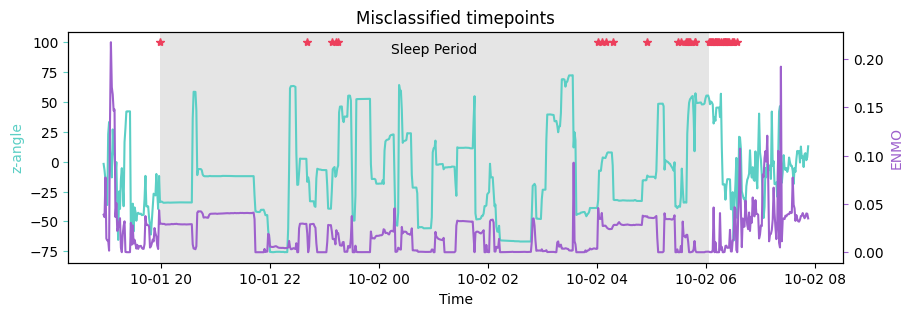

In [89]:
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plot the 'z_angle' values on y-axis
ax1.plot(X_pat['timestamp'], X_pat['anglez'], label='z-angle', color = '#5BCFC5')
# label the timepoints of misclassification
ax1.plot(X_pat.query('misclassified == 1')['timestamp'], [100]*sum(X_pat['misclassified']), marker='*', linestyle='', color = '#ED3F5C')
ax1.set_xlabel('Time')
ax1.set_ylabel('z-angle', color = '#5BCFC5')
ax1.tick_params('y', color = '#5BCFC5')
#ax1.legend(loc='upper left')

# Create a secondary y-axis for 'enmo'
ax2 = ax1.twinx()
ax2.plot(X_pat['timestamp'], X_pat['enmo'], label='ENMO', color='#9E61CD')
ax2.set_ylabel('ENMO', color='#9E61CD')
ax2.tick_params('y', color='#9E61CD')
start_time = rand_pat[rand_pat['event'] == 'onset']['timestamp'][0]
end_time = rand_pat[rand_pat['event'] == 'wakeup']['timestamp'][0]

# mark sleep period
rect = Rectangle((start_time, ax1.get_ylim()[0]), end_time - start_time, ax1.get_ylim()[1] - ax1.get_ylim()[0],
                 linewidth=0, edgecolor='none', facecolor='#CCCCCC', alpha=0.5)
ax1.add_patch(rect)
label_text = 'Sleep Period'
ax1.text(start_time + (end_time - start_time) / 2, ax1.get_ylim()[1] -15, label_text,
         ha='center', va='center', color='black', fontsize=10)

plt.title('Misclassified timepoints')
plt.show()

In [90]:
file ='patient_44a41bba1ee7_6.0_random_60_180_minutes.parquet'
rand_pat = get_rand_pat(file)
X_pat, y_pat = make_X_y_pat(rand_pat)
y_pat_pred = predicted_y_pat(X_pat, model)
X_pat = modify_X_pat(X_pat, rand_pat, y_pat_pred)

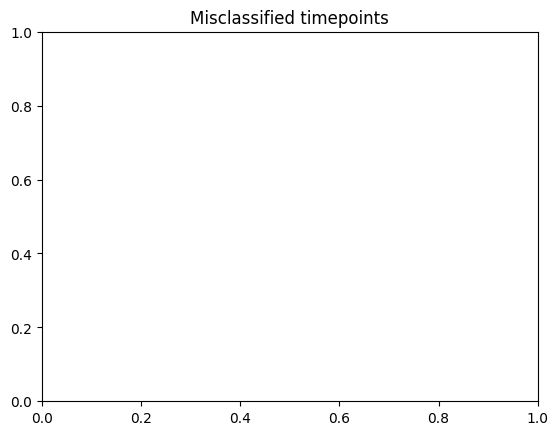

In [95]:
# Plot the 'z_angle' values on y-axis
ax1.plot(X_pat['timestamp'], X_pat['anglez'], label='z-angle', color = '#5BCFC5')
# label the timepoints of misclassification
ax1.plot(X_pat.query('misclassified == 1')['timestamp'], [100]*sum(X_pat['misclassified']), marker='*', linestyle='', color = '#ED3F5C')
ax1.set_xlabel('Time')
ax1.set_ylabel('z-angle', color = '#5BCFC5')
ax1.tick_params('y', color = '#5BCFC5')
#ax1.legend(loc='upper left')

# Create a secondary y-axis for 'enmo'
ax2 = ax1.twinx()
ax2.plot(X_pat['timestamp'], X_pat['enmo'], label='ENMO', color='#9E61CD')
ax2.set_ylabel('ENMO', color='#9E61CD')
ax2.tick_params('y', color='#9E61CD')
start_time = rand_pat[rand_pat['event'] == 'onset']['timestamp'][0]
end_time = rand_pat[rand_pat['event'] == 'wakeup']['timestamp'][0]

# mark sleep period
rect = Rectangle((start_time, ax1.get_ylim()[0]), end_time - start_time, ax1.get_ylim()[1] - ax1.get_ylim()[0],
                 linewidth=0, edgecolor='none', facecolor='#CCCCCC', alpha=0.5)
ax1.add_patch(rect)
label_text = 'Sleep Period'
ax1.text(start_time + (end_time - start_time) / 2, ax1.get_ylim()[1] -15, label_text,
         ha='center', va='center', color='black', fontsize=10)

plt.title('Misclassified timepoints')
plt.show()

In [96]:
X_pat.query('misclassified == 1')

,anglez,enmo,anglez_std,enmo_std,slope_enmo,slope_anglez,anglez_outside_45_counter,enmo_over_008_counter,anglez_difference_5_per_min,anglez_5min_mean,...,enmo_10min_mean_shifted,enmo_10min_std_shifted,minutes_since_onset,year,month,day,hour,minute,timestamp,misclassified
164,-22.128693,0.016617,27.481063,0.021853,0.004448,4.765815,1,7,5,-34.885440,...,0.011483,0.007379,0.0,2018.0,2.0,28.0,7.0,30.0,2018-02-28 07:30:00,1
402,17.221149,0.020992,17.756886,0.018739,0.001105,-0.242339,0,7,9,-2.106100,...,0.001828,0.003939,238.0,2018.0,2.0,28.0,11.0,28.0,2018-02-28 11:28:00,1
403,-14.084541,0.045042,14.183423,0.047086,0.007172,1.526300,0,6,5,-2.117702,...,0.001828,0.003939,239.0,2018.0,2.0,28.0,11.0,29.0,2018-02-28 11:29:00,1
404,-18.213642,0.072967,30.446524,0.035725,0.000715,2.144134,2,11,12,-7.309913,...,0.001828,0.003939,240.0,2018.0,2.0,28.0,11.0,30.0,2018-02-28 11:30:00,1
405,-12.448074,0.029325,18.232448,0.032634,0.001121,-3.740074,0,7,7,-7.854262,...,0.000742,0.002345,241.0,2018.0,2.0,28.0,11.0,31.0,2018-02-28 11:31:00,1
406,-5.931784,0.037800,14.279026,0.037423,0.003708,-0.035341,0,10,4,-6.691378,...,0.000000,0.000000,242.0,2018.0,2.0,28.0,11.0,32.0,2018-02-28 11:32:00,1
407,14.425334,0.037992,17.838333,0.034047,-0.002147,2.893035,1,9,9,-7.250541,...,0.001124,0.003555,243.0,2018.0,2.0,28.0,11.0,33.0,2018-02-28 11:33:00,1
408,-9.325150,0.004542,13.330741,0.007714,-0.000639,-1.263316,0,2,3,-6.298663,...,0.003248,0.007242,244.0,2018.0,2.0,28.0,11.0,34.0,2018-02-28 11:34:00,1
409,12.080283,0.046075,27.293365,0.024724,0.002628,-5.052957,3,12,8,-0.239878,...,0.008317,0.016517,245.0,2018.0,2.0,28.0,11.0,35.0,2018-02-28 11:35:00,1
410,-3.877008,0.069775,11.942796,0.034896,0.002483,-2.394180,0,12,8,1.474335,...,0.011531,0.017796,246.0,2018.0,2.0,28.0,11.0,36.0,2018-02-28 11:36:00,1
